In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer

import plotly as py
import plotly.graph_objs as go

import warnings
warnings.filterwarnings('ignore')

In [129]:
!pip install pmdarima

# Load Data


In [130]:
data_Customer = pd.read_csv('Customer.csv', sep=';')
data_Product = pd.read_csv('Product.csv', sep=';')
data_Store = pd.read_csv('Store.csv', sep=';')
data_Transaction = pd.read_csv('Transaction.csv', sep=';')

In [131]:
data_Customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"


In [132]:
data_Customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB


In [133]:
data_Product.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [134]:
data_Product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


In [135]:
data_Store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"


In [136]:
data_Store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StoreID     14 non-null     int64 
 1   StoreName   14 non-null     object
 2   GroupStore  14 non-null     object
 3   Type        14 non-null     object
 4   Latitude    14 non-null     object
 5   Longitude   14 non-null     object
dtypes: int64(1), object(5)
memory usage: 800.0+ bytes


In [137]:
data_Transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [138]:
data_Transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB


# Data Merged and Cleansing


In [139]:
data_temp1 = pd.merge(data_Transaction, data_Customer, on='CustomerID', how='inner')
data_temp2 = pd.merge(data_temp1, data_Store, on = 'StoreID', how = 'inner')
df_merged = pd.merge(data_temp2, data_Product, on = 'ProductID', how = 'inner')
df_merged.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,StoreName,GroupStore,Type,Latitude,Longitude,Product Name,Price_y
0,TR11369,328,01/01/2022,P3,7500,4,30000,12,36,0,Married,"10,53",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
1,TR89318,183,17/07/2022,P3,7500,1,7500,12,27,1,Single,"0,18",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
2,TR9106,123,26/09/2022,P3,7500,4,30000,12,34,0,Married,"4,36",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
3,TR4331,335,08/01/2022,P3,7500,3,22500,12,29,1,Single,"4,74",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
4,TR6445,181,10/01/2022,P3,7500,4,30000,12,33,1,Married,"9,94",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500


In [140]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   TransactionID   5020 non-null   object
 1   CustomerID      5020 non-null   int64 
 2   Date            5020 non-null   object
 3   ProductID       5020 non-null   object
 4   Price_x         5020 non-null   int64 
 5   Qty             5020 non-null   int64 
 6   TotalAmount     5020 non-null   int64 
 7   StoreID         5020 non-null   int64 
 8   Age             5020 non-null   int64 
 9   Gender          5020 non-null   int64 
 10  Marital Status  4976 non-null   object
 11  Income          5020 non-null   object
 12  StoreName       5020 non-null   object
 13  GroupStore      5020 non-null   object
 14  Type            5020 non-null   object
 15  Latitude        5020 non-null   object
 16  Longitude       5020 non-null   object
 17  Product Name    5020 non-null   object
 18  Price_y 

In [141]:
(df_merged['Price_x']/df_merged['Price_y']).value_counts()

1.0    5020
dtype: int64

In [142]:
df_merged.drop(columns ='Price_y', inplace = True)

In [143]:
df_merged.isna().sum()

TransactionID      0
CustomerID         0
Date               0
ProductID          0
Price_x            0
Qty                0
TotalAmount        0
StoreID            0
Age                0
Gender             0
Marital Status    44
Income             0
StoreName          0
GroupStore         0
Type               0
Latitude           0
Longitude          0
Product Name       0
dtype: int64

In [144]:
df_merged.dropna(inplace = True)
df_merged.isna().sum()

TransactionID     0
CustomerID        0
Date              0
ProductID         0
Price_x           0
Qty               0
TotalAmount       0
StoreID           0
Age               0
Gender            0
Marital Status    0
Income            0
StoreName         0
GroupStore        0
Type              0
Latitude          0
Longitude         0
Product Name      0
dtype: int64

In [145]:
df_merged.duplicated().sum()

0

In [146]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4976 entries, 0 to 5019
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   TransactionID   4976 non-null   object
 1   CustomerID      4976 non-null   int64 
 2   Date            4976 non-null   object
 3   ProductID       4976 non-null   object
 4   Price_x         4976 non-null   int64 
 5   Qty             4976 non-null   int64 
 6   TotalAmount     4976 non-null   int64 
 7   StoreID         4976 non-null   int64 
 8   Age             4976 non-null   int64 
 9   Gender          4976 non-null   int64 
 10  Marital Status  4976 non-null   object
 11  Income          4976 non-null   object
 12  StoreName       4976 non-null   object
 13  GroupStore      4976 non-null   object
 14  Type            4976 non-null   object
 15  Latitude        4976 non-null   object
 16  Longitude       4976 non-null   object
 17  Product Name    4976 non-null   object
dtypes: int64

In [147]:
df_merged['TransactionID'] = df_merged['TransactionID'].astype('string')
df_merged['CustomerID'] = df_merged['CustomerID'].astype('string')
df_merged['Date'] = pd.to_datetime(df_merged['Date'], format='%d/%m/%Y')
df_merged['ProductID'] = df_merged['ProductID'].astype('string')
df_merged['StoreName'] = df_merged['StoreName'].astype('string')
df_merged['GroupStore'] = df_merged['GroupStore'].astype('string')
df_merged['Type'] = df_merged['Type'].astype('|S')
df_merged['Longitude'] = df_merged['Longitude'].apply(lambda x: x.replace(',','.')).astype(float)
df_merged['Latitude'] = df_merged['Latitude'].apply(lambda x: x.replace(',','.')).astype(float)
df_merged['Marital Status'] = df_merged['Marital Status'].astype('string')
df_merged['Income'] = df_merged['Income'].apply(lambda x: x.replace(',','.')).astype(float)
df_merged['Product Name'] = df_merged['Product Name'].astype('string')

In [148]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4976 entries, 0 to 5019
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   4976 non-null   string        
 1   CustomerID      4976 non-null   string        
 2   Date            4976 non-null   datetime64[ns]
 3   ProductID       4976 non-null   string        
 4   Price_x         4976 non-null   int64         
 5   Qty             4976 non-null   int64         
 6   TotalAmount     4976 non-null   int64         
 7   StoreID         4976 non-null   int64         
 8   Age             4976 non-null   int64         
 9   Gender          4976 non-null   int64         
 10  Marital Status  4976 non-null   string        
 11  Income          4976 non-null   float64       
 12  StoreName       4976 non-null   string        
 13  GroupStore      4976 non-null   string        
 14  Type            4976 non-null   |S13          
 15  Lati

In [149]:
df_merged.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,StoreName,GroupStore,Type,Latitude,Longitude,Product Name
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Prestasi Utama,Prestasi,b'General Trade',-2.990934,104.756554,Crackers
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Prestasi Utama,Prestasi,b'General Trade',-2.990934,104.756554,Crackers
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Prestasi Utama,Prestasi,b'General Trade',-2.990934,104.756554,Crackers
3,TR4331,335,2022-01-08,P3,7500,3,22500,12,29,1,Single,4.74,Prestasi Utama,Prestasi,b'General Trade',-2.990934,104.756554,Crackers
4,TR6445,181,2022-01-10,P3,7500,4,30000,12,33,1,Married,9.94,Prestasi Utama,Prestasi,b'General Trade',-2.990934,104.756554,Crackers


# **Time Series Forecasting**

**Time Series Analysis**

In [150]:
df_arima = df_merged.groupby('Date', as_index =True)['Qty'].sum()
df_arima = pd.DataFrame(df_arima)
df_arima.head()

,Qty
Date,
2022-01-01,49
2022-01-02,59
2022-01-03,63
2022-01-04,45
2022-01-05,28


<Axes: title={'center': 'Time Series Visualisation'}, xlabel='Date'>

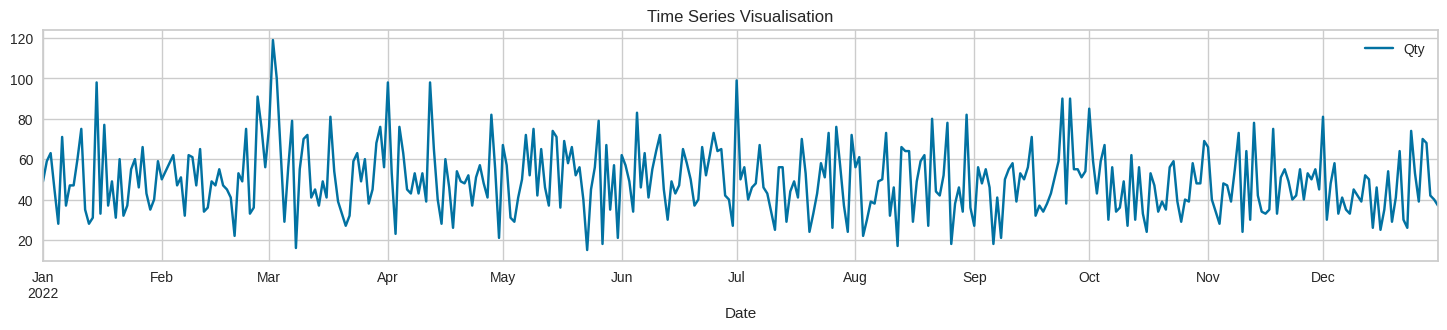

In [151]:
df_arima.plot(figsize=(18,3), title='Time Series Visualisation')

In [152]:
print(f"Orignal Time Series Data Shape = {df_arima.shape}")
test_size = round(df_arima.shape[0] * 0.2)
train=df_arima.iloc[:-1*(test_size)]
test=df_arima.iloc[-1*(test_size):]
print(f"Training Time Series Data Shape = {train.shape}")
print(f"Test Time Series Data Shape = {test.shape}")

Orignal Time Series Data Shape = (365, 1)
Training Time Series Data Shape = (292, 1)
Test Time Series Data Shape = (73, 1)


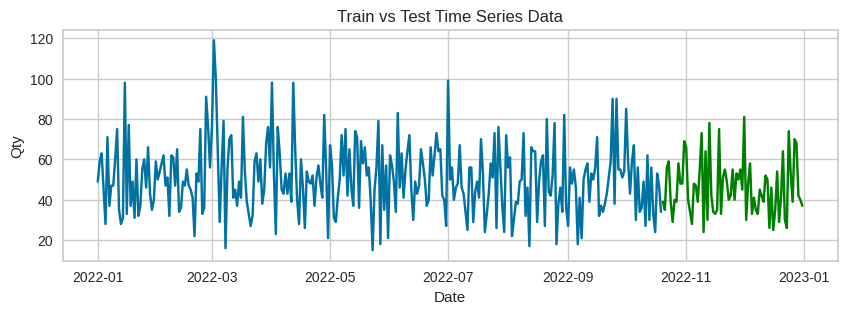

In [153]:
plt.figure(figsize=(10,3))
sns.lineplot(data=train, x=train.index, y=train['Qty'])
sns.lineplot(data=test, x=test.index, y=test['Qty'], color='green')
plt.title('Train vs Test Time Series Data')
plt.show()


**Check for Stationary**

In [185]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] < 0.05:
      print("Strong objection towards Null Hypothesis. This indicate time series has no unit root, therefore it is stationary")
    else:
      print("Weak to reject Null Hypothesis. This indicate time series has unit root, therefore it is non stationary")

adf_test(df_arima)

Results of Dickey-Fuller Test:
Test Statistic                 -19.248302
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64
Strong objection towards Null Hypothesis. This indicate time series has no unit root, therefore it is stationary


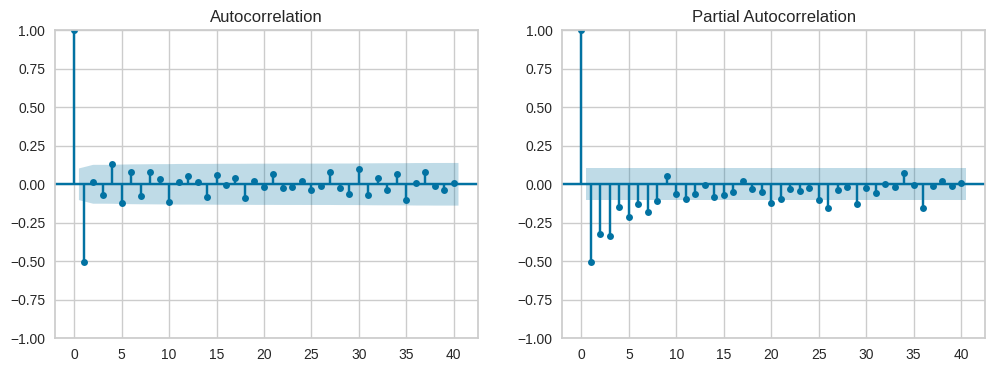

In [155]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df_arima.diff().dropna(), lags=40, ax=ax[0])
plot_pacf(df_arima.diff().dropna(), lags=40, ax=ax[1])
plt.show()

**Modelling**

**Auto Arima**

In [156]:
model_auto = pm.auto_arima(train,test='adf',
                      seasonal=False,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=False)

print(model_auto.summary())

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3154.015, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2967.924, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2854.318, Time=0.12 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2815.561, Time=0.13 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=2753.494, Time=0.27 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=2739.996, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2686.138, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2509.752, Time=0.56 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=2511.101, Time=0.65 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2615.212, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2508.280, Time=0.31 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.62 sec
 ARIMA(3,0,0)(0,0,0)[0]       

**Hyperparameter Tuning**

In [157]:
p = range(0, 5)
d = range(0, 5)
q = range(0, 5)

pdq = list(product(p, d, q))
print(pdq)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 2, 4), (0, 3, 0), (0, 3, 1), (0, 3, 2), (0, 3, 3), (0, 3, 4), (0, 4, 0), (0, 4, 1), (0, 4, 2), (0, 4, 3), (0, 4, 4), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 0, 4), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 1, 4), (1, 2, 0), (1, 2, 1), (1, 2, 2), (1, 2, 3), (1, 2, 4), (1, 3, 0), (1, 3, 1), (1, 3, 2), (1, 3, 3), (1, 3, 4), (1, 4, 0), (1, 4, 1), (1, 4, 2), (1, 4, 3), (1, 4, 4), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 0, 3), (2, 0, 4), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 1, 4), (2, 2, 0), (2, 2, 1), (2, 2, 2), (2, 2, 3), (2, 2, 4), (2, 3, 0), (2, 3, 1), (2, 3, 2), (2, 3, 3), (2, 3, 4), (2, 4, 0), (2, 4, 1), (2, 4, 2), (2, 4, 3), (2, 4, 4), (3, 0, 0), (3, 0, 1), (3, 0, 2), (3, 0, 3), (3, 0, 4), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 1, 3), (3, 1, 4), (3, 2, 0), (3, 2, 1), (3, 2, 2), (3, 2, 3), (3, 2, 4), (3, 3, 0)

In [158]:
from statsmodels.tsa.arima.model import ARIMA
aic_scores = []
for param in pdq:
    model = ARIMA(df_arima, order=param)
    model_fit = model.fit()
    aic_scores.append({'par': param, 'aic': model_fit.aic})

best_aic = min(aic_scores, key=lambda x: x['aic'])
print(best_aic)

{'par': (0, 1, 1), 'aic': 3090.7666642019835}


In [159]:
model_hyper = ARIMA(train, order=best_aic['par'])
model_fit_hyper = model_hyper.fit()

**Manual Hyperparameter**

In [192]:
model_manual = ARIMA(train, order=(40,2,2))
model_fit_manual = model_manual.fit()

**Plot Forecasting**

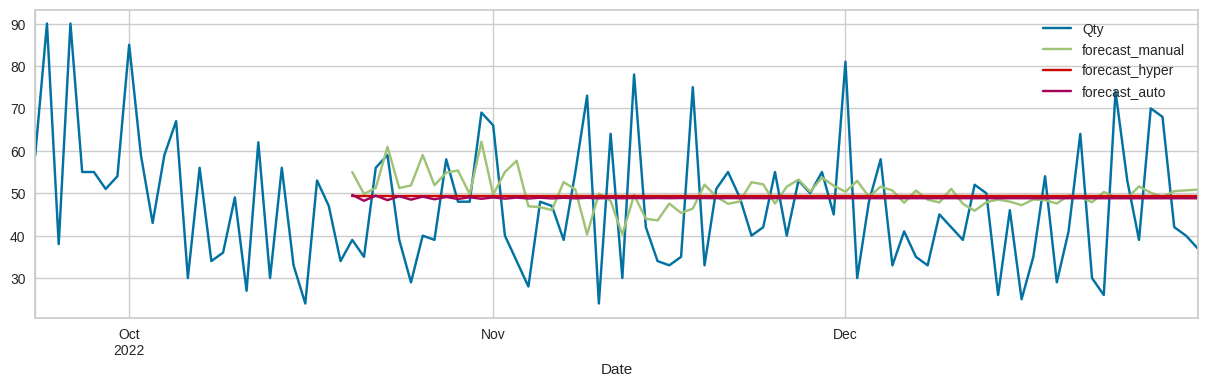

In [194]:
manual_forecast = model_fit_manual.forecast(len(test))
ht_forecast = model_fit_hyper.forecast(len(test))
auto_forecast = model_auto.predict(len(test))

df_plot = df_arima.iloc[-100:]

df_plot['forecast_manual'] = [None]*(len(df_plot)-len(manual_forecast)) + list(manual_forecast)
df_plot['forecast_hyper'] = [None]*(len(df_plot)-len(ht_forecast)) + list(ht_forecast)
df_plot['forecast_auto'] = [None]*(len(df_plot)-len(auto_forecast)) + list(auto_forecast)

df_plot.plot(figsize=(15,4))
plt.show()

**Metrics Evaluation**

In [162]:
mae = mean_absolute_error(test, manual_forecast)
mape = mean_absolute_percentage_error(test, manual_forecast)
rmse = np.sqrt(mean_squared_error(test, manual_forecast))

print(f'Mean Absolute Error - manual            : {round(mae,4)}')
print(f'Mean Absolute Percentage Error - manual : {round(mape,4)}')
print(f'Root Mean Square Error - manual         : {round(rmse,4)}')

Mean Absolute Error - manual            : 12.1105
Mean Absolute Percentage Error - manual : 0.303
Root Mean Square Error - manual         : 14.681


**Forecasting Quantity Sales with Best Parameter**

In [163]:
model = ARIMA(df_arima, order=(40, 2, 2))
model_fit = model.fit()
arima_forecast = model_fit.forecast(steps=31)

In [164]:
arima_forecast

2023-01-01    48.032620
2023-01-02    52.771970
2023-01-03    42.415548
2023-01-04    42.371087
2023-01-05    48.184608
2023-01-06    42.588385
2023-01-07    41.250563
2023-01-08    42.012141
2023-01-09    47.379681
2023-01-10    47.040452
2023-01-11    39.379183
2023-01-12    38.310967
2023-01-13    39.579069
2023-01-14    43.966695
2023-01-15    35.687121
2023-01-16    42.231282
2023-01-17    47.299585
2023-01-18    44.852787
2023-01-19    40.623193
2023-01-20    46.828698
2023-01-21    43.228274
2023-01-22    39.244635
2023-01-23    50.856941
2023-01-24    51.581725
2023-01-25    41.013727
2023-01-26    47.031478
2023-01-27    50.280388
2023-01-28    41.314691
2023-01-29    42.729599
2023-01-30    49.428432
2023-01-31    45.003954
Freq: D, Name: predicted_mean, dtype: float64

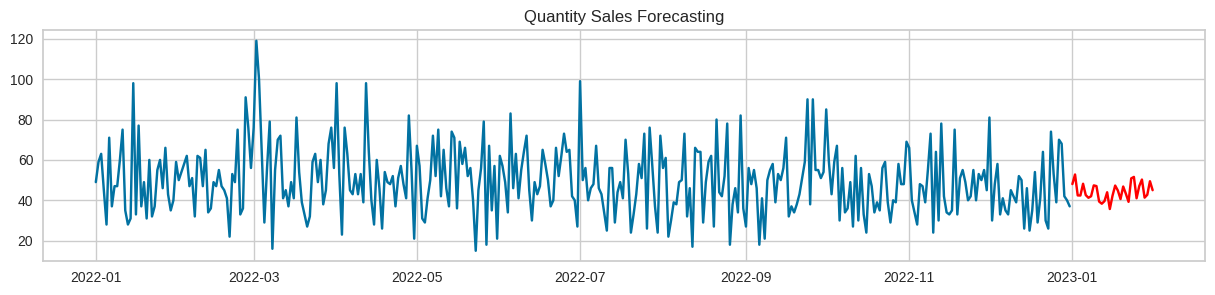

In [165]:
plt.figure(figsize=(15,3))
plt.plot(df_arima)
plt.plot(arima_forecast,color='red')
plt.title('Quantity Sales Forecasting')
plt.show()

# **Clustering**

In [166]:
df_merged.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,StoreName,GroupStore,Type,Latitude,Longitude,Product Name
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Prestasi Utama,Prestasi,b'General Trade',-2.990934,104.756554,Crackers
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Prestasi Utama,Prestasi,b'General Trade',-2.990934,104.756554,Crackers
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Prestasi Utama,Prestasi,b'General Trade',-2.990934,104.756554,Crackers
3,TR4331,335,2022-01-08,P3,7500,3,22500,12,29,1,Single,4.74,Prestasi Utama,Prestasi,b'General Trade',-2.990934,104.756554,Crackers
4,TR6445,181,2022-01-10,P3,7500,4,30000,12,33,1,Married,9.94,Prestasi Utama,Prestasi,b'General Trade',-2.990934,104.756554,Crackers


In [167]:
df_clust = df_merged.groupby('CustomerID').agg({'TransactionID':'count',
                                                   'Qty':'sum',
                                                   'TotalAmount':'sum'}).reset_index()
df_clust

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,100,8,35,272400
2,101,14,44,439600
3,102,15,57,423300
4,103,11,31,318200
...,...,...,...,...
439,95,12,43,410200
440,96,12,44,355100
441,97,14,36,329500
442,98,9,34,362500


In [168]:
df_clust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     444 non-null    string
 1   TransactionID  444 non-null    int64 
 2   Qty            444 non-null    int64 
 3   TotalAmount    444 non-null    int64 
dtypes: int64(3), string(1)
memory usage: 14.0 KB


In [169]:
df_cluster = df_clust.drop(columns = ['CustomerID'])
df_cluster.head()

,TransactionID,Qty,TotalAmount
0,17,60,623300
1,8,35,272400
2,14,44,439600
3,15,57,423300
4,11,31,318200


In [170]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   TransactionID  444 non-null    int64
 1   Qty            444 non-null    int64
 2   TotalAmount    444 non-null    int64
dtypes: int64(3)
memory usage: 10.5 KB


In [171]:
df_cluster.isna().sum()

TransactionID    0
Qty              0
TotalAmount      0
dtype: int64

In [172]:
X = df_cluster.values
X_std = StandardScaler().fit_transform(X)
df_std = pd.DataFrame(data=X_std,columns=df_cluster.columns)
df_std.isna().sum()

TransactionID    0
Qty              0
TotalAmount      0
dtype: int64

In [173]:
X_std

array([[ 1.78828224,  1.50893374,  2.10242393],
       [-0.99009094, -0.45808499, -0.71705167],
       [ 0.86215784,  0.25004175,  0.62639752],
       ...,
       [ 0.86215784, -0.37940424, -0.25825413],
       [-0.68138281, -0.53676574,  0.00690031],
       [-0.68138281, -0.61544649, -0.36351241]])

In [174]:
df_std

,TransactionID,Qty,TotalAmount
0,1.788282,1.508934,2.102424
1,-0.990091,-0.458085,-0.717052
2,0.862158,0.250042,0.626398
3,1.170866,1.272891,0.495427
4,-0.063967,-0.772808,-0.349049
...,...,...,...
439,0.244742,0.171361,0.390169
440,0.244742,0.250042,-0.052559
441,0.862158,-0.379404,-0.258254
442,-0.681383,-0.536766,0.006900


In [175]:
wcss= []
for n in range (1,11):
    model1 = KMeans(n_clusters=n, init='k-means++', n_init = 10, max_iter=100, tol =0.0001, random_state = 100)
    model1.fit(X_std)
    wcss.append(model1.inertia_)
print(wcss)

[1332.0000000000002, 543.4711248616256, 316.55344988206656, 237.6047257597112, 191.11956602309147, 169.3256849311349, 153.26819803282265, 140.30071190330494, 129.87879883321608, 121.01992784419895]


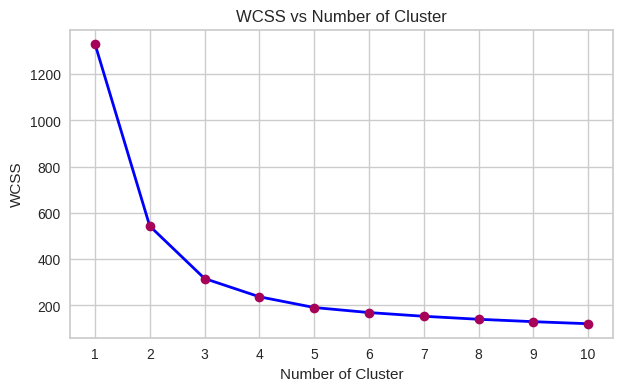

In [200]:
plt.figure(figsize=(7,4))
plt.plot(list(range(1,11)), wcss, color = 'blue', marker = 'o', linewidth=2, markersize=7, markerfacecolor= 'm',
         markeredgecolor= 'm')
plt.title('WCSS vs Number of Cluster')
plt.xlabel('Number of Cluster')
plt.ylabel('WCSS')
plt.xticks(list(range(1,11)))
plt.show()

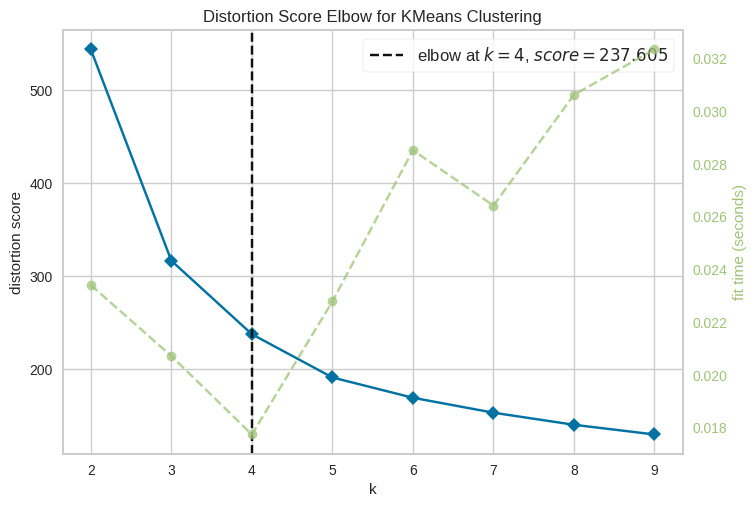

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [177]:
#Elbow Method with yellowbrick library
visualizer = KElbowVisualizer(model1, k=(2,10))
visualizer.fit(X_std)
visualizer.show()

In [178]:
K = range(2,8)
fits=[]
score=[]

for k in K:
    model = KMeans(n_clusters = k, random_state = 0, n_init= 'auto').fit(X_std)
    fits.append(model)
    score.append(silhouette_score(X_std, model.labels_, metric='euclidean'))

<Axes: >

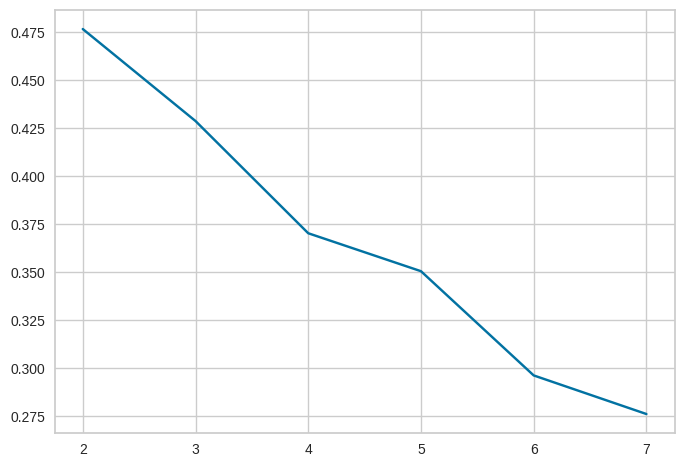

In [179]:
sns.lineplot(x = K, y = score)

In [180]:
# Kmeans n_cluster = 4
#Clustering Kmeans
kmeans_4 = KMeans(n_clusters=4,init='k-means++',max_iter=300,n_init=10,random_state=100)
kmeans_4.fit(X_std)

KMeans(n_clusters=4, n_init=10, random_state=100)

In [181]:
# Masukin cluster ke dataset
df_cluster['cluster'] = kmeans_4.labels_
df_cluster.head()

,TransactionID,Qty,TotalAmount,cluster
0,17,60,623300,2
1,8,35,272400,0
2,14,44,439600,3
3,15,57,423300,3
4,11,31,318200,0


<Figure size 600x600 with 0 Axes>

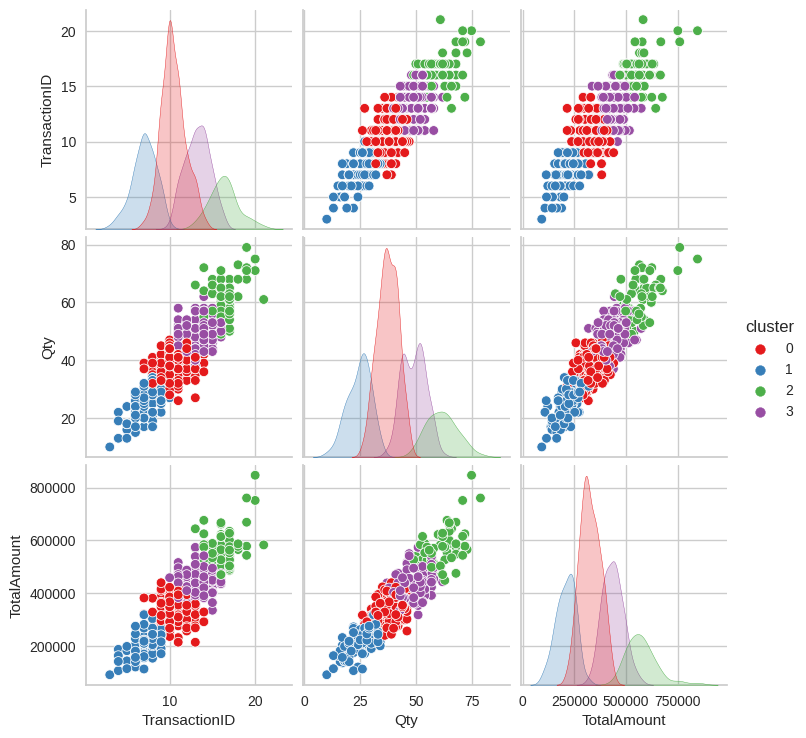

In [182]:
plt.figure(figsize=(6,6))
sns.pairplot(data=df_cluster,hue='cluster',palette='Set1')
plt.show()

In [183]:
df_cluster['CustomerID'] = df_clust['CustomerID']
df_cluster_mean = df_cluster.groupby('cluster').agg({'CustomerID':'count','TransactionID':'mean','Qty':'mean','TotalAmount':'mean'})
df_cluster_mean.sort_values('CustomerID', ascending = False)

,CustomerID,TransactionID,Qty,TotalAmount
cluster,,,,
0,180,10.427778,37.350000,325663.333333
3,113,13.247788,49.070796,435833.628319
1,93,7.021505,24.505376,208283.870968
2,58,16.362069,61.689655,574650.000000


**Cluster 0:**

Cluster dengan jumlah pelanggan terbanyak diantara cluster lainnnya. Cluster ini menempati posisi 3 tertinggi dari penilaian tiap fitur yang ada. Strategi yang dapat diterapkan untuk cluster pelanggan ini ialah sebagai berikut:
*   Memberikan bonus poin sebagai keterlibatan mereka sebagai member loyal untuk mempertahankan transaksi dan juga meningkatkan peminatan.
*   Melakukan survei secara berkala supaya dapat mengetahui kepuasan dan penat cluster pelanggan ini

**Cluster 1:**

Cluster dengan jumlah pelanggan ketiga paling banyak diantara cluster lainnnya. Cluster ini menempati posisi terendah dari penilaian tiap fitur yang ada. Strategi yang dapat diterapkan untuk cluster pelanggan ini ialah sebagai berikut:
*   Menawarkan paket promo yang menarik untuk meningkatkan peminatan cluster pelanggan untuk bertransaksi
*   Melakukan survei secara intens untuk dapat mempetakan sentimen cluster pelanggan terhadap produk
*   Menyediakan layanan customer service untuk membantu cluster pelanggan memahami produk-produk lebih baik

**Cluster 2:**

Cluster dengan jumlah pelanggan terendah diantara cluster lainnnya. Cluster ini menempati posisi tertinggi dari penilaian tiap fitur yang ada. Strategi yang dapat diterapkan untuk cluster pelanggan ini ialah sebagai berikut:
*   Menawarkan program membership untuk mempertahankan atau bahkan meningkatkan transaksi.
*   Memberikan update atau info terkini lebih cepat dari pada cluster lainnya supaya dapat meningkatkan antusias terhadap produk yang ada.

**Cluster 3:**
Cluster dengan jumlah pelanggan kedua paling banyak diantara cluster lainnnya. Cluster ini menempati posisi kedua paling tinggi dari penilaian tiap fitur yang ada. Strategi yang dapat diterapkan untuk cluster pelanggan ini ialah sebagai berikut:
*   Menerapkan produk upselling
*   Mengadakan promo-promo menarik untuk mempertahankan transaksi
*   Memasarkan program membership untuk meningkatkan minat bertransaksi


In [184]:
trace1 = go.Scatter3d(
    x= df_cluster['TransactionID'],
    y= df_cluster['Qty'],
    z= df_cluster['TotalAmount'],
    mode='markers',
     marker=dict(
        color = df_cluster['cluster'],
        size= 10,
        line=dict(
            color= df_cluster['cluster'],
            width= 12
        ),
        opacity=0.8
     )
)
data = [trace1]
layout = go.Layout(
    title= 'Clusters wrt TransactionID, Qty and Spending TotalAmount',
    scene = dict(
            xaxis = dict(title  = 'TransactionID Count'),
            yaxis = dict(title  = 'Quantity'),
            zaxis = dict(title  = 'Total Amount')
        )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)